<h1>RL-based trading algos</h1>

In [54]:
%pip install gym
%pip install numpy
%pip install torch

import gym
import numpy as np
from gym import spaces
import torch
import random
from collections import deque
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import uts
from consts import *

utils = uts.Utilities(is_test=IS_TEST, test_num=TEST_NUM)
etf_dfs = utils.get_dataframes('data/ETFs')
stock_dfs = utils.get_dataframes('data/Stocks') 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Episode 1, Reward: 0.00, Epsilon: 0.0977
Final Portfolio Value: 2044714.44
Episode 2, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 1657348.77
Episode 3, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 3221733.01
Episode 4, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 1879350.02
Episode 5, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 2406217.95
Episode 6, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 1324500.66
Episode 7, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 2362134.76
Episode 8, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 1841500.31
Episode 9, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 1772477.89
Episode 10, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 1506248.11
Episode 11, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 1728987.04
Episode 12, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 1151645.28
Episode 13, Reward: 0.00, Epsilon: 0.0100
Final Portfolio Value: 3945434.12
Episode 14, Reward: 0

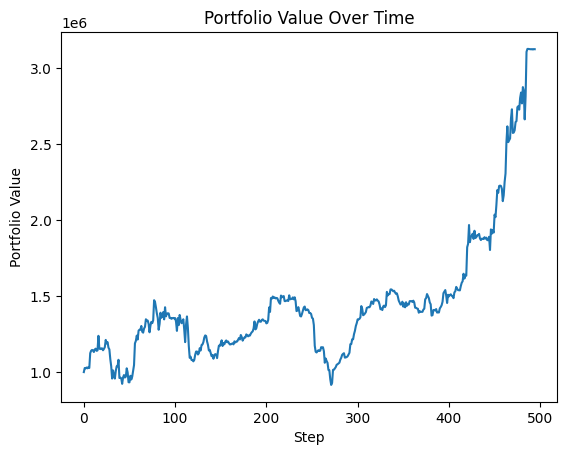

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class TradingEnv(gym.Env):
    def __init__(self, prices, window_size=10, initial_cash=INIT_CASH):
        super().__init__()
        self.prices = prices
        self.window_size = window_size
        self.initial_cash = initial_cash
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(window_size,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.cash = self.initial_cash
        self.shares = 0
        self.current_step = self.window_size
        self.done = False
        self.initial_cash_val = self.initial_cash
        return self._get_state()

    def _get_state(self):
        return self.prices[self.current_step - self.window_size:self.current_step]

    def step(self, action):
        prev_price = self.prices[self.current_step]
        prev_value = self.cash + self.shares * prev_price

        if action == 1:
            shares_to_buy = int(self.cash / prev_price)
            self.cash -= shares_to_buy * prev_price
            self.shares += shares_to_buy
        elif action == 2 and self.shares > 0:
            self.cash += self.shares * prev_price
            self.shares = 0

        self.current_step += 1
        if self.current_step >= len(self.prices):
            self.done = True

        price = self.prices[self.current_step - 1]
        total_value = self.cash + self.shares * price
        reward = total_value - prev_value  # dense reward
        return self._get_state(), reward, self.done, {}


    def get_value(self):
        return self.cash + self.shares * self.prices[self.current_step-1]

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.batch_size = 32

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice([0, 1, 2])  # Hold, Buy, Sell
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, s, a, r, s2, done):
        self.memory.append((s, a, r, s2, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        s, a, r, s2, d = zip(*batch)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s2 = torch.FloatTensor(s2)
        d = torch.FloatTensor(d).unsqueeze(1)

        q = self.model(s).gather(1, a)
        q_next = self.target_model(s2).max(1)[0].unsqueeze(1)
        q_target = r + self.gamma * q_next * (1 - d)

        loss = nn.MSELoss()(q, q_target.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

prices = stock_dfs[0]['Close'].values
env = TradingEnv(prices)
agent = DQNAgent(state_size=env.window_size, action_size=3)

EPISODES = 50
for ep in range(EPISODES):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        total_reward += reward

        if done:
            break

    agent.update_target()
    print(f"Episode {ep + 1}, Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

    final_value = env.get_value()
    print(f"Final Portfolio Value: {final_value:.2f}")

portfolio_values = []

state = env.reset()
while True:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    portfolio_values.append(env.get_value())

    state = next_state
    if done:
        break
dqn_values = portfolio_values.copy()

plt.plot(portfolio_values)
plt.title("Portfolio Value Over Time")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.show()


In [56]:
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

class PPOAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, clip=0.2, lr=1e-4):
        self.gamma = gamma
        self.clip = clip

        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def compute_returns(self, rewards, dones, next_value):
        returns = []
        R = next_value
        for r, d in zip(reversed(rewards), reversed(dones)):
            R = r + self.gamma * R * (1 - d)
            returns.insert(0, R)
        return returns

    def update(self, trajectories):
        states, actions, log_probs_old, rewards, next_states, dones = zip(*trajectories)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        old_log_probs = torch.stack(log_probs_old).detach()
        dones = torch.FloatTensor(dones)
        next_states = torch.FloatTensor(next_states)

        with torch.no_grad():
            next_value = self.critic(next_states[-1]).item()
            returns = self.compute_returns(rewards, dones, next_value)
            returns = torch.FloatTensor(returns)
            advantages = returns - self.critic(states).squeeze()

        # Optimize actor and critic
        for _ in range(4):  # multiple epochs
            probs = self.actor(states)
            dist = torch.distributions.Categorical(probs)
            log_probs = dist.log_prob(actions)

            ratio = (log_probs - old_log_probs).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip, 1 + self.clip) * advantages

            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = nn.MSELoss()(self.critic(states).squeeze(), returns)

            self.optimizer_actor.zero_grad()
            actor_loss.backward()
            self.optimizer_actor.step()

            self.optimizer_critic.zero_grad()
            critic_loss.backward()
            self.optimizer_critic.step()


In [57]:
prices = stock_dfs[0]['Close'].values
env = TradingEnv(prices)
agent = PPOAgent(state_dim=env.window_size, action_dim=3)

EPISODES = 50

for ep in range(EPISODES):
    state = env.reset()
    trajectory = []
    total_reward = 0

    while True:
        action, log_prob = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        trajectory.append((state, action, log_prob, reward, next_state, done))
        total_reward += reward
        state = next_state

        if done:
            break

    agent.update(trajectory)
    print(f"Episode {ep + 1}, Reward: {total_reward:.2f}")

    final_value = env.get_value()
    print(f"Final Portfolio Value: {final_value:.2f}")


Episode 1, Reward: 0.00
Final Portfolio Value: 2372914.22
Episode 2, Reward: 0.00
Final Portfolio Value: 2723357.86
Episode 3, Reward: 0.00
Final Portfolio Value: 3114579.39
Episode 4, Reward: 0.00
Final Portfolio Value: 2881368.84
Episode 5, Reward: 0.00
Final Portfolio Value: 2782963.51
Episode 6, Reward: -0.00
Final Portfolio Value: 3152713.84
Episode 7, Reward: 0.00
Final Portfolio Value: 3122192.79
Episode 8, Reward: 0.00
Final Portfolio Value: 2883135.28
Episode 9, Reward: 0.00
Final Portfolio Value: 2828489.53
Episode 10, Reward: 0.00
Final Portfolio Value: 2472262.16
Episode 11, Reward: 0.00
Final Portfolio Value: 3034483.12
Episode 12, Reward: 0.00
Final Portfolio Value: 2773098.55
Episode 13, Reward: 0.00
Final Portfolio Value: 3087047.11
Episode 14, Reward: -0.00
Final Portfolio Value: 3953224.48
Episode 15, Reward: 0.00
Final Portfolio Value: 2759164.93
Episode 16, Reward: 0.00
Final Portfolio Value: 3504980.57
Episode 17, Reward: 0.00
Final Portfolio Value: 3248355.00
Epis

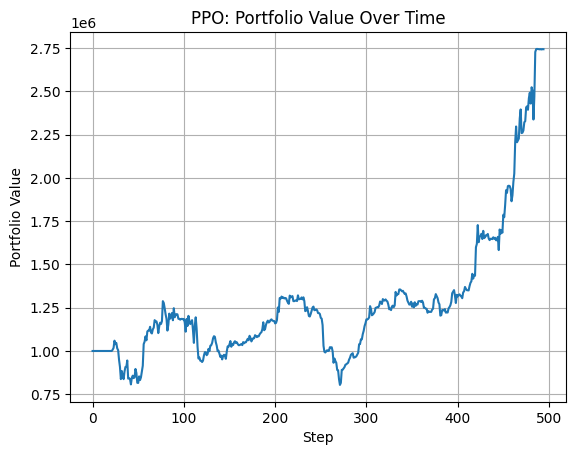

In [58]:
# Plot portfolio values over time after training
ppo_values = []

state = env.reset()
while True:
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs = agent.actor(state_tensor)
        action = torch.argmax(probs, dim=-1).item()
    next_state, _, done, _ = env.step(action)
    ppo_values.append(env.get_value())
    state = next_state
    if done:
        break
ppo_values = ppo_values.copy()

plt.plot(ppo_values)
plt.title("PPO: Portfolio Value Over Time")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


In [59]:
class DDPGActor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

class DDPGCritic(nn.Module):
    def __init__(self, input_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + action_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.net(x)

class DDPGAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, tau=0.005):
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim + action_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.target_actor = nn.Sequential(*[layer for layer in self.actor])
        self.target_critic = nn.Sequential(*[layer for layer in self.critic])
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = deque(maxlen=10000)
        self.batch_size = 32

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state_tensor).squeeze().numpy()
        return np.random.choice(len(action_probs), p=action_probs)

    def remember(self, s, a, r, s2, done):
        a_onehot = np.zeros(3)
        a_onehot[a] = 1
        self.replay_buffer.append((s, a_onehot, r, s2, done))

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.sample(self.replay_buffer, self.batch_size)
        s, a, r, s2, d = zip(*batch)

        s = torch.FloatTensor(s)
        a = torch.FloatTensor(a)
        r = torch.FloatTensor(r).unsqueeze(1)
        s2 = torch.FloatTensor(s2)
        d = torch.FloatTensor(d).unsqueeze(1)

        with torch.no_grad():
            a2 = self.target_actor(s2)
            q_next = self.target_critic(torch.cat([s2, a2], dim=1))
            q_target = r + self.gamma * q_next * (1 - d)

        q_current = self.critic(torch.cat([s, a], dim=1))
        critic_loss = nn.MSELoss()(q_current, q_target)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        action_pred = self.actor(s)
        actor_loss = -self.critic(torch.cat([s, action_pred], dim=1)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


In [60]:
prices = stock_dfs[0]['Close'].values
env = TradingEnv(prices)
agent = DDPGAgent(state_dim=env.window_size, action_dim=3)

EPISODES = 50
for ep in range(EPISODES):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward

        if done:
            break

    print(f"Episode {ep+1}, Reward: {total_reward:.2f}")
    print(f"Final Portfolio Value: {env.get_value():.2f}")


Episode 1, Reward: 0.00
Final Portfolio Value: 2488761.66
Episode 2, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 3, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 4, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 5, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 6, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 7, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 8, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 9, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 10, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 11, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 12, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 13, Reward: 0.00
Final Portfolio Value: 1139594.24
Episode 14, Reward: 0.00
Final Portfolio Value: 1087982.93
Episode 15, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 16, Reward: 0.00
Final Portfolio Value: 1000000.00
Episode 17, Reward: 0.00
Final Portfolio Value: 1000000.00
Episod

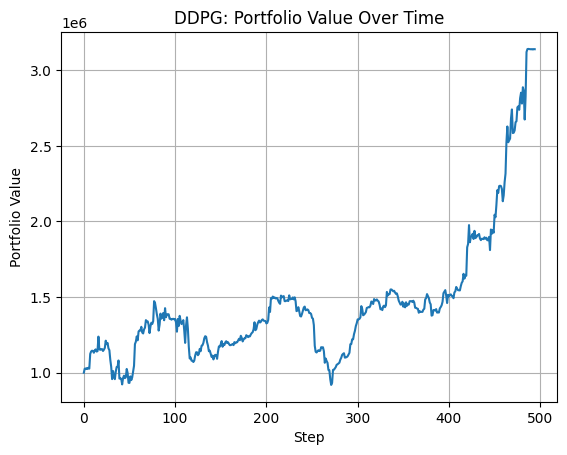

In [61]:
portfolio_values = []
state = env.reset()
while True:
    action = agent.select_action(state)
    next_state, _, done, _ = env.step(action)
    portfolio_values.append(env.get_value())
    state = next_state
    if done:
        break
ddpg_values = portfolio_values.copy()

plt.plot(portfolio_values)
plt.title("DDPG: Portfolio Value Over Time")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()

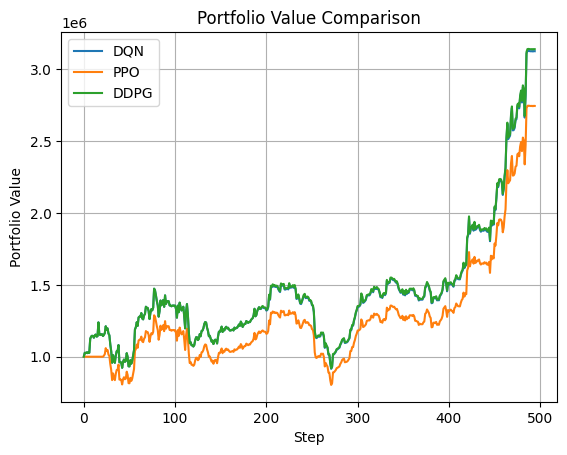

In [62]:
plt.plot(dqn_values, label='DQN')
plt.plot(ppo_values, label='PPO')
plt.plot(ddpg_values, label='DDPG')
plt.legend()
plt.title("Portfolio Value Comparison")
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()